# SAT scores and NYC High Schools

#### Reading in the data

In [15]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### Reading in the surveys

In [16]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#### Adding DBN columns

In [17]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### Converting columns to numeric

In [18]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### Condensing datasets

In [19]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### Converting AP scores to numeric

In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

#### Combining the datasets

In [21]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### Adding a school district column for mapping

In [22]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

#### Finding correlations

In [23]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

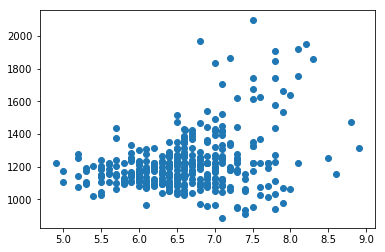

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(combined['saf_s_11'],combined['sat_score'])
plt.show()

Students' safety scores seem to be positively correlated with sat scores.

In [25]:
combined.columns

Index(['DBN', 'SCHOOL NAME', 'Num of SAT Test Takers',
       'SAT Critical Reading Avg. Score', 'SAT Math Avg. Score',
       'SAT Writing Avg. Score', 'sat_score', 'SchoolName', 'AP Test Takers ',
       'Total Exams Taken',
       ...
       'priority05', 'priority06', 'priority07', 'priority08', 'priority09',
       'priority10', 'Location 1', 'lat', 'lon', 'school_dist'],
      dtype='object', length=160)

In [26]:
avg_saf_by_dist = combined.pivot_table(index = 'school_dist', values = 'sat_score', columns = ['lat','lon'])

In [27]:
#print(avg_saf_by_dist)
districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)
districts

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
5,06,382.011940,400.565672,382.066269,1164.643881,108.711538,159.715385,105.425000,180.848387,6.0,...,12.0,12.0,10036.200000,628.900000,1.300000,0.0,0.0,0.0,40.848970,-73.932502
6,07,376.461538,380.461538,371.923077,1128.846154,73.703402,112.476331,105.276923,105.605459,7.0,...,12.0,12.0,10452.692308,465.846154,1.461538,0.0,0.0,0.0,40.816815,-73.919971
7,08,386.214383,395.542741,377.908005,1159.665129,118.379371,168.020979,144.731818,215.510264,8.0,...,12.0,12.0,10467.000000,547.636364,1.272727,0.0,0.0,0.0,40.823803,-73.866087
8,09,373.755970,383.582836,374.633134,1131.971940,71.411538,104.265385,98.470000,113.330645,9.0,...,12.0,12.0,10456.100000,449.700000,1.150000,0.0,0.0,0.0,40.836349,-73.906240
9,10,403.363636,418.000000,400.863636,1222.227273,132.231206,226.914336,191.618182,161.318182,10.0,...,12.0,12.0,10463.181818,757.863636,1.500000,0.0,0.0,0.0,40.870345,-73.898360


In [28]:
from mpl_toolkits.basemap import Basemap

fig = plt.figure(figsize=[10,8])
plt.title('Average Safety Scores by District')
m = Basemap(projection='merc', llcrnrlat=40.496044, urcrnrlat=40.915256, llcrnrlon=-74.255735, urcrnrlon=-73.700272, resolution ='i')
lats = districts['lat'].tolist()
lons = districts['lon'].tolist()
m.scatter(lons, lats, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.drawcoastlines()
plt.show()

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

Safety scores of schools as opined by students seem to be higher in Northern parts of Brooklyn and lower in The Bronx and Manhattan.

In [ ]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[races].plot.bar()

From observing correlations between composition of different races and SAT scores, it looks like percent of Whites and Asians have a statistically significant positive correlation with SAT scores. On the other hand, percent of Blacks and Hispanics have insufficiently statistically significant negative correlation to SAT scores.

In [ ]:
combined.plot('hispanic_per','sat_score',kind='scatter')

A weak-moderate correlation can be found between percent of Hispanics and SAT scores. A school having close to 0% Hispanics has the highesh Avg SAT score and schools with nearly 100% Hispanics are observed to have some of the lowest SAT scores. Then again, there are also schools with low percent of Hispanics that produced low avg SAT scores.

In [ ]:
hisp_more_than_95 = combined[combined['hispanic_per']>95]
hisp_more_than_95

All 8 schools that have a hispanic composition of over 95% cater to primarily new Hispanic immigrants who have poor knowledge of English. This explains why the schools' average SAT scores suffer.

In [ ]:
hisp_less_than_10_and_SAT_over_1800 = combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]
hisp_less_than_10_and_SAT_over_1800

All 5 schools that have Hispanic percent less than 10 and an avg SAT score greater than 1800 are highly selective, top schools in the US and they admit students based on their SHSAT (specialized high schools admissions test) scores.

In [ ]:
genders = ['male_per','female_per']
correlations[genders].plot.bar()

Both male percent and female percent seem to have no statistically significant correlation between them and sat scores.

In [ ]:
combined.plot('female_per','sat_score',kind='scatter')

No correlation between female percent and sat scores can be found.

In [ ]:
female_over_60_SAT_over_1700 = combined[(combined['female_per']>60) & (combined['sat_score']>1700)]
female_over_60_SAT_over_1700

Nothing of interest with regards to correlation between female percent and sat_score could be perceived from the investigation except that these schools are highly selective schools that are very well-renowned for an intensive curriculum and college prep.

In [ ]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined['ap_per']

In [ ]:
combined.plot('ap_per','sat_score',kind='scatter')

Percent of AP test takers and Avg SAT scores seem to have a weak positive correlation.